Data from Kaggle:

https://www.kaggle.com/antfarol/car-sale-advertisements

https://www.kaggle.com/satadru5/car-sale-prediction

http://localhost:8888/notebooks/0-MyCollection/Regression-CarSale/01-Car_Sale_LinearRegression-NumericalVariables-01.ipynb

# Importing the relevant libraries

In [15]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set()

# Loading the raw data

In [20]:
raw_data = pd.read_csv('CarSale.csv')
print(raw_data.shape)

raw_data.head()

(4345, 9)


,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


This is a list of second hand cars with the respective price of body, mileage, engine volume, engine type, production model and information about the time when they were registered. What we would like to do is predict the price of a used car depending on its specifications. 

    + The first potential aggressor is brand as it is well-known that a BMW is generally more expensive than a Toyota. 
    + The second relevant variable is mileage since the more a car is driven the cheaper it should be. 
    + Third, the engine volume, sports cars have larger engines and economy cars have smaller engines
    + The final variable is year of production, the older the car, the cheaper it is with the exception of vintage vehicles
    + The rest are categorical variables which we'll deal with on a case by case basis

# Descriptive Statistics

### Data structure

In [21]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4345 entries, 0 to 4344
Data columns (total 9 columns):
Brand           4345 non-null object
Price           4173 non-null float64
Body            4345 non-null object
Mileage         4345 non-null int64
EngineV         4195 non-null float64
Engine Type     4345 non-null object
Registration    4345 non-null object
Year            4345 non-null int64
Model           4345 non-null object
dtypes: float64(2), int64(2), object(5)
memory usage: 305.6+ KB


### Exploring the descriptive statistics of the variables

In [22]:
# Descriptive statistics are very useful for initial exploration of the variables.
# Note that categorical variables don't have some types of numerical descriptives
# and numerical variables don't have some types of categorical descriptives

raw_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Brand,4345,7,Volkswagen,936,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,4173,NaN,NaN,NaN,19418.7,25584.2,600,6999,11500,21700,300000
Body,4345,6,sedan,1649,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mileage,4345,NaN,NaN,NaN,161.237,105.706,0,86,155,230,980
EngineV,4195,NaN,NaN,NaN,2.79073,5.06644,0.6,1.8,2.2,3,99.99
Engine Type,4345,4,Diesel,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Registration,4345,2,yes,3947,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,4345,NaN,NaN,NaN,2006.55,6.7191,1969,2003,2008,2012,2016
Model,4345,312,E-Class,199,NaN,NaN,NaN,NaN,NaN,NaN,NaN


1. **count**: First thing, we notice that each variable has a different number of observations which implies there are some missing values
2. **unique entries**: There are three hundred and twelve unique values in Model variable. That's something really hard to implement and a regression that would mean more than 300 dummies. So we drop this variable
3. **freq**: Another piece of information we obtain is the most common category. Frequency registration for instance is three thousand nine hunderd forty seven yes entries. Almost all of them looks like this variable won't be very useful. 
4. A lot of information for model could be engineered from brand, year and engine volume so we wont' losing too much variability

### Determining the variables of interest

In [24]:
# Frist, create the regression without 'Model'
data = raw_data.drop(['Model'],axis=1)
# Check the description without 'Model'
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Brand,4345,7,Volkswagen,936,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,4173,NaN,NaN,NaN,19418.7,25584.2,600,6999,11500,21700,300000
Body,4345,6,sedan,1649,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mileage,4345,NaN,NaN,NaN,161.237,105.706,0,86,155,230,980
EngineV,4195,NaN,NaN,NaN,2.79073,5.06644,0.6,1.8,2.2,3,99.99
Engine Type,4345,4,Diesel,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Registration,4345,2,yes,3947,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,4345,NaN,NaN,NaN,2006.55,6.7191,1969,2003,2008,2012,2016


# Check missing values

### Count num of missing values for each feature

In [5]:
data.isnull().sum()

Brand             0
Price           172
Body              0
Mileage           0
EngineV         150
Engine Type       0
Registration      0
Year              0
dtype: int64

brand, body, mileage, engine type, registration and years seem to have no missing values given that the total number of observations is four thousand three hundred and forty five. We can't say the same thing about price and engine volume. 

### Check relationship between values being missing and target

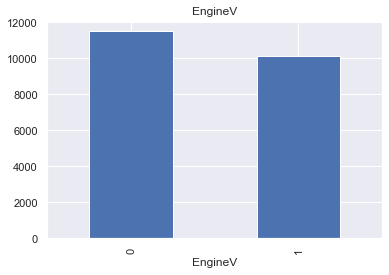

In [25]:
var_list = ['EngineV']

def analyze_na_values(df, var, target):
    df = df.copy()
    
    # Make a variable that indicates 1 if the observation was missing or 0 otherwise
    df[var] = np.where(df[var].isnull(),1,0)
    
    # Calculate the mean Price where the information is missing or present
    df.groupby(var)[target].median().plot.bar()
    plt.title(var)
    plt.show()
    
for var in var_list:
    analyze_na_values(data, var, 'Price')

### Approach 1: Remove rows with missing values

A rule of thumb is that if you are removing less than 5 percent of observations, you are free to just remove all observations that have missing values. In this case they are less than that, so we are safe

In [34]:
# Lest's simply drop all missing values
# This is not always recommended, however, when we remove less than 5% of the data, it is okay
df_missing_data = data.copy()
data = data.dropna(axis=0)
data.reset_index(drop=True,inplace=True)
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Brand,4025,7,Volkswagen,880,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,4025,NaN,NaN,NaN,19552.3,25815.7,600,6999,11500,21900,300000
Body,4025,6,sedan,1534,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mileage,4025,NaN,NaN,NaN,163.572,103.395,0,90,158,230,980
EngineV,4025,NaN,NaN,NaN,2.76459,4.93594,0.6,1.8,2.2,3,99.99
Engine Type,4025,4,Diesel,1861,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Registration,4025,2,yes,3654,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,4025,NaN,NaN,NaN,2006.38,6.6956,1969,2003,2007,2012,2016


# Variable Examination

### Target variable

In [62]:
target_var = 'Price'

### Numerical variables

In [63]:
num_vars = [var for var in data.columns if data[var].dtypes != 'O' and var != target_var]
print('Num of numerical variables',len(num_vars))
data[num_vars].head()

Num of numerical variables 3


,Mileage,EngineV,Year
0,277,2.0,1991
1,427,2.9,1999
2,358,5.0,2003
3,240,4.2,2007
4,120,2.0,2011


### Discrete variables

In [64]:
dis_vars = [var for var in num_vars if len(data[var].unique())<20 and var not in target]
print('Number of discrete variables: ', len(dis_vars))
data[dis_vars].head()

Number of discrete variables:  0


""
0
1
2
3
4


### Continuous variables

In [65]:
# List of continuous variables
cont_vars = [var for var in num_vars if var not in dis_vars]
print('Number of continous variables: ', len(cont_vars))
data[cont_vars].head()

Number of continous variables:  3


,Mileage,EngineV,Year
0,277,2.0,1991
1,427,2.9,1999
2,358,5.0,2003
3,240,4.2,2007
4,120,2.0,2011


#### Correlation matrix

[]

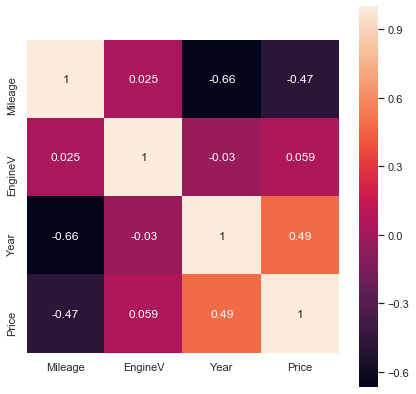

In [67]:
corr = data[cont_vars + [target_var]].corr()
plt.figure(figsize = (7,7))
sns.heatmap(data = corr, annot = True, square = True, cbar = True)
plt.plot()

#### Distribution Plot

In [68]:
def analyse_continuous(df,var,target,title):
    df = df.copy()
    # df[var] = df[var].fillna(df[var].median())
    plt.figure(figsize=(21,6))
       
    # histogram
    plt.subplot(141)
    sns.distplot(df[var], bins=30)
    #sns.distplot(df[var],hist=True, kde=True,kde_kws={'shade': True, 'linewidth': 3})
    plt.title('Histogram')    
    
    # Q-Q plot
    plt.subplot(142)
    stats.probplot(df[var], dist="norm", plot=pylab)
    plt.ylabel('Quantiles')    
    
    # boxplot
    sns.boxplot(x=df[var])
    plt.title('Boxplot')
    plt.subplot(143)
    
    ## scatter plot
    plt.subplot(144)
    plt.scatter(df[var],df[target])
    plt.title('scatter plot')
    
    # skewness and kurtosis
    print('Skewness: %f' % df[var].skew())
    print('Kurtosis: %f' % df[var].kurt())
    plt.title(title)
    plt.show()

Skewness: 0.700196
Kurtosis: 1.809798


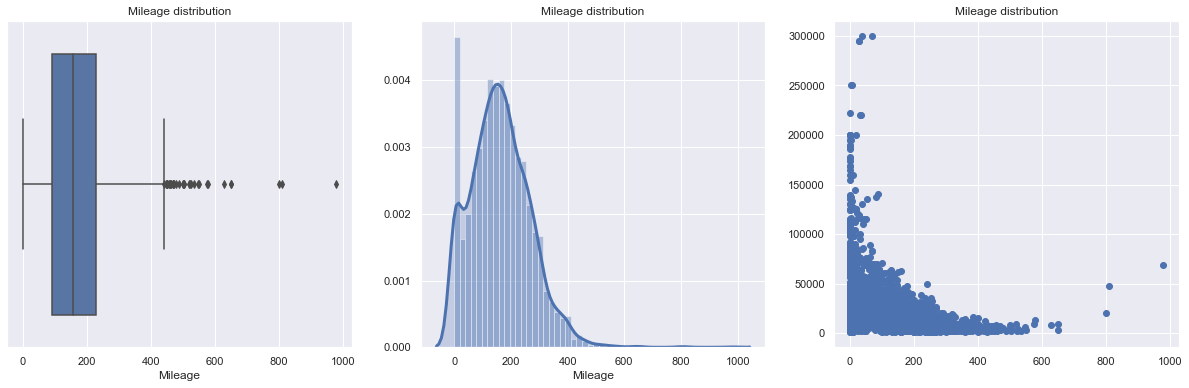

Skewness: 17.154962
Kurtosis: 316.181652


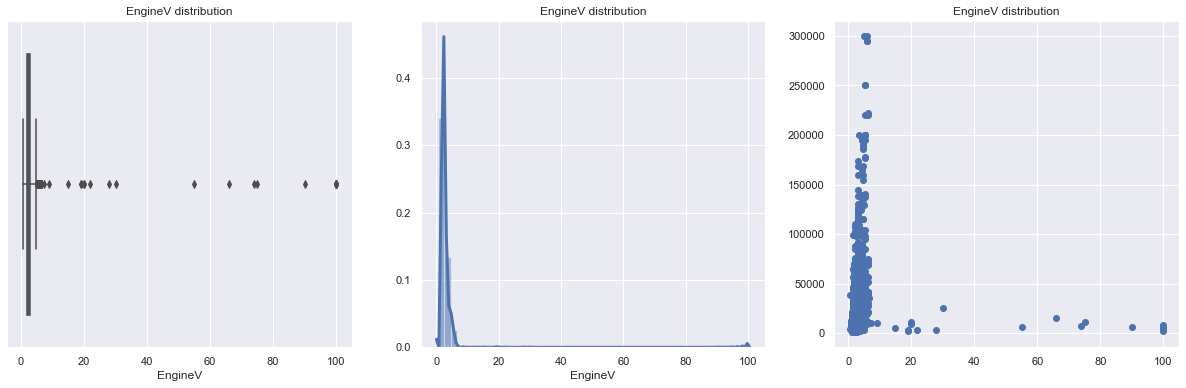

Skewness: -0.963945
Kurtosis: 0.999387


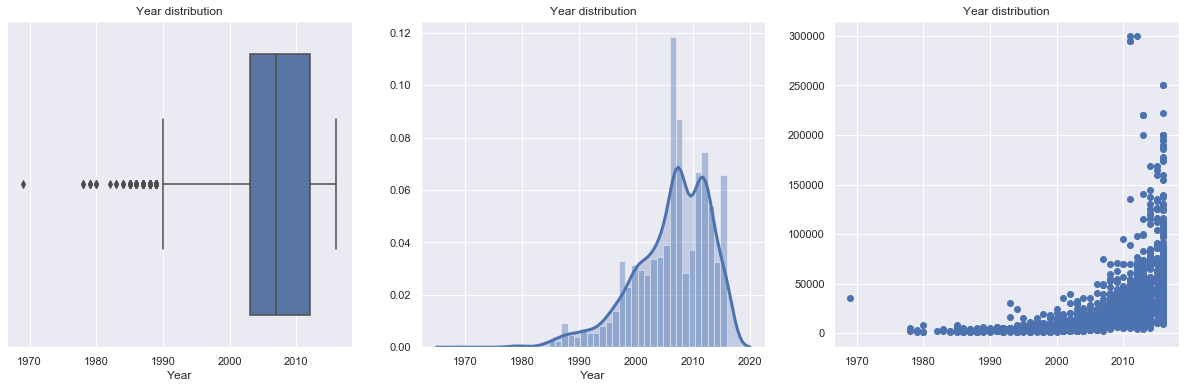

In [70]:
for var in cont_vars:
    analyse_continuous(data,var,target_var,str(var)+' distribution')

### Categorical variables

### Temporal variables

# Build model without preprocessing

In [71]:
num_df = data[num_vars]
target = data['Price']

### Scaling numeric features

In [72]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(num_df)
input_scaled = scaler.transform(num_df)
input_scaled = pd.DataFrame(input_scaled, columns = num_df.columns)

### Creating dummy vars for categorical features

In [73]:
input_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
Mileage,4025.0,-6.108295e-17,1.000124,-1.582214,-0.711655,-0.053899,0.642548,7.897206
EngineV,4025.0,-1.221935e-17,1.000124,-0.438590,-0.195445,-0.114397,0.047700,19.699890
Year,4025.0,3.581952e-16,1.000124,-5.583413,-0.504817,0.092665,0.839518,1.437000


### Train test split 

In [74]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_scaled, target, test_size=0.2, random_state =365)

### Built model

In [75]:
import statsmodels.api as sm
X = sm.add_constant(X_train)
results = sm.OLS(y_train, X).fit()

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### Result

In [76]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     409.0
Date:                Thu, 04 Jun 2020   Prob (F-statistic):          4.92e-225
Time:                        21:57:50   Log-Likelihood:                -36910.
No. Observations:                3220   AIC:                         7.383e+04
Df Residuals:                    3216   BIC:                         7.385e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.98e+04    405.829     48.787      0.0

In [77]:
model = LinearRegression()
model.fit(X_train, y_train)

print('Train score: ', model.score(X_train, y_train))
print('Test score: ', model.score(X_test, y_test))

Train score:  0.27614939316938114
Test score:  0.3168038440457036
